# Natural Language Processing
### Patricia Llull Sperandio

# Table of contents
[0.Imports and Functions](#0) <br>
[1.Inspect the data](#1) <br>
[2.Baseline Models without pre-processing](#2) <br> 
[3.Keeping duplicated rows](#3) <br>
[4.Data cleaning and pre-processing](#4) <br>
[5.Applying ML techniques](#5) <br>


https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
[line for line in train_df['text'] if 'okwx' in line]


Tweets about disaster are bound to be more formal since users are tweeting about a serious topic (posted by people on site, news agencies, government authorities...).
In contrast, tweets that are not about disasters can contain typos, abbreviations, slang etc
look for duplicates just to check (there should be none).
look for mislabelled tweets
- https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e

Infromation from <a href = 'https://www.kaggle.com/c/nlp-getting-started/data'>Kaggle</a>:

Twitter data
train/test contain:
- text of a tweet
- keyword from that tweet (can be blank) -> deal with NA's
- location (can also be blank) --> NA's

Predict
- tweet about disaster (1) or not (0)


Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# 0. Imports and functions <a class="anchor" id="0"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
%matplotlib inline

from IPython.core.display import display, HTML
from IPython.display import Markdown as md


display(HTML("<style>.container { width:70% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size


In [2]:
# functions

 #for plotting confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    # for getting metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

# feature importance plot
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


## get feature importance important words
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

# cleaning the text column

def standardize_text(dataset, text):
    dataset[text] = dataset[text].str.replace(r"http\S+", "")
    dataset[text] = dataset[text].str.replace(r"http", "")
    dataset[text] = dataset[text].str.replace(r"@\S+", "")
    dataset[text] = dataset[text].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    dataset[text] = dataset[text].str.replace(r"@", "at")
    #dataset[text] = dataset[text].str.replace(r"?","") #remove question marks
    #dataset[text] = dataset[text].str.replace(r"!","") # remove exclamation marks
    #dataset[text] = dataset[text].str.replace(r"(", "") #remove paranthese
    #dataset[text] = dataset[text].str.replace(r")","") #remove other paranthese
    dataset[text] = dataset[text].str.lower()
    return dataset


#cleaning the keyword column
def standardize_keyword(dataset, keyword):
    dataset[keyword] = dataset[keyword].str.replace(r"%20", " ")
    dataset[keyword] = dataset[keyword].str.lower()
    return dataset


#plot importance of words
import matplotlib
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

#latent seman
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','pink','pink']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Irrelevant')
            green_patch = mpatches.Patch(color='pink', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 12})

In [3]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv') 

# 1. Inspect the data <a class="anchor" id="1"></a>
- The training dataset is more or less balanced
- Length of tweets
- Missing values in columns location and keyword
- Overview of tweets content: some examples

## A. Target values: 0 vs. 1

The dataset is more or less balanced. There are 3271 tweets for target 1 (disaster), and 4342 for 0 (not disaster).

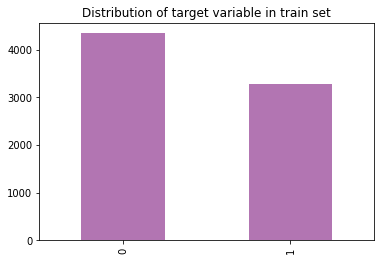

In [4]:
train_df_target_1 = len(train_df[train_df['target']==1])
target_df_target_0 = len(train_df[train_df['target']==0])
train_df['target'].value_counts().plot(kind='bar', title = 'Distribution of target variable in train set', color =(0.5,0.1,0.5,0.6))
#train_df.groupby('target').count()
md(f'The dataset is more or less balanced. There are {train_df_target_1} tweets for target 1 (disaster), and {target_df_target_0} for 0 (not disaster).')

## B. Length of tweets
- We could think that the number of words per tweet might be helpful to classify the tweet as disaster or not. This is because we can think of tweets about disaster as more formal
- However, by looking at the distribution (target = 1 vs. target = 0) we can see that we might not be able to extract information from the number of words

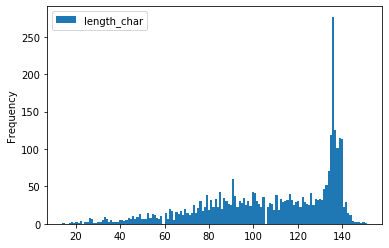

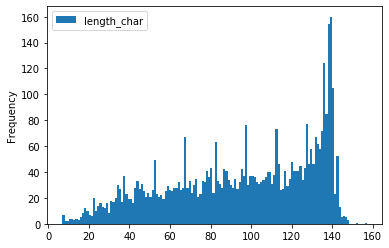

In [5]:
train_df['length_char'] = train_df['text'].str.len()
plot_1 = train_df[train_df['target']==1]
plot_1.plot(y='length_char', kind= 'hist', bins=140)

plot_0 = train_df[train_df['target']==0]
plot_0.plot(y='length_char', kind= 'hist', bins=140)


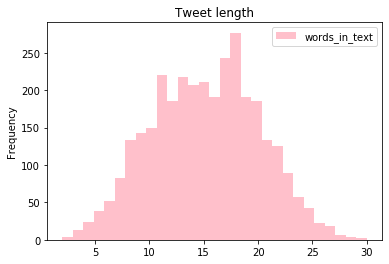

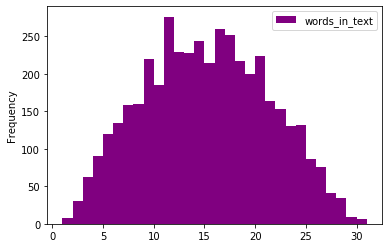

In [6]:
#similar distribution for target =1 and target =0
train_df['words_in_text'] = train_df['text'].map(lambda x: len(str(x).split()))
plots_1 = train_df[train_df['target']==1]
bins_1  = plots_1['words_in_text'].max()-1
plots_1.plot(y='words_in_text', kind = 'hist', bins=bins_1, color= 'pink')
plt.title('Tweet length')
plots_0 = train_df[train_df['target'] ==0]
bins_0 = plots_0['words_in_text'].max() -1
plots_0.plot(y='words_in_text', kind='hist', bins= bins_0, color = 'purple')
#train_df = train_df.drop('words_in_text', axis=1) # drop that column we created since we don't need it for now

## C. Missing values
As indicated by Kaggle, there are some missing values: let's check them out.
The plot below shows there are many missing values for the location and some for the keyword. More information in section D.


The total amount of missing values is 2594. Below is a more detailed table:


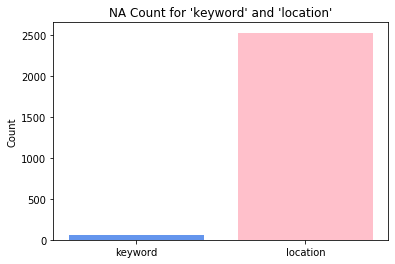

Most of the missing values are for the location with 2533 missing values. This represents 33.0% of the total number of observations in the training dataset

In [7]:
# analyse the missing values
missing_values_total = train_df.isna().sum().sum()
missing_keyword = train_df['keyword'].isna().sum().sum()
missing_values =['keyword','location']
print(f'The total amount of missing values is {missing_values_total}. Below is a more detailed table:' )
missing_location =train_df['location'].isna().sum().sum()
train_df.isna().sum()
plt.bar(x= train_df[missing_values].isna().sum().index, height = train_df[missing_values].isna().sum().values, color= ('cornflowerblue', 'pink'))
plt.title("NA Count for 'keyword' and 'location'")
plt.ylabel("Count")
plt.show()
percentage_na_location = round(missing_location/train_df.shape[0],2)*100
md(f'Most of the missing values are for the location with {missing_location} missing values. This represents {percentage_na_location}% of the total number of observations in the training dataset')

## D. Overview of the contents
- look at a sentence:
    - sentences in twitter data are not exactly sentences as described in grammar books
    - users resort to 'SMS'like text because of the word limit, and use abbreviations
    - there is also a possibility to find messages with typos (voluntary or not)
    - people use smileys / emojis
    - messages contain special characters like #, @...
- look at tweets for which we have the location: 
    - as we can see below, the locations descriptions are noisy
    - there is not a speific way to describe one location, and as we saw in part C, there is a significant proportion of missing values. Therefore, we should not use location as a feature.
- look at keyword
    
- look at the vocabulary 

In [8]:
print('Twitter data content is noisy and sparse:');print(train_df['text'][1]);print(train_df['text'][28])

Twitter data content is noisy and sparse:
Forest fire near La Ronge Sask. Canada
Cooool :)


In [9]:
print('Location - many ways to describe one place:')
train_df.loc[train_df.location.notna(), ['location', 'text']] 
train_df['location'] = train_df['location'].astype(str)
london_format = len([line for line in train_df['location'] if 'london' in line or 'London' in line])
print(f'There are',london_format, 'different formats for the city of London!')

Location - many ways to describe one place:
There are 116 different formats for the city of London!


In [10]:
#Vocabulary for the train dataset
train_df['tokens'] = [nltk.word_tokenize(words) for words in train_df['text']]

# vocabulary for train dataset
all_words = [word for tokens in train_df['tokens'] for word in tokens]
#len(all_words)

sentence_lengths = [len(tokens) for tokens in train_df['tokens']]

vocab = sorted(list(set(all_words)))
len(vocab)
print('Before we start processing the data i.e. before using regular expressions to treat the text.')
print("There are %s words in total, with a vocabulary size of %s" % (len(all_words), len(vocab)),'.')
print("Max sentence length is %s" % max(sentence_lengths),'.')
print('So we can see that there are some pre-processing steps to take before applying ML techniques.')

# drop the column created to look at the vocabulary ; drop it and re-create it after appending train & test set (see steps below)
train_df = train_df.drop('tokens', axis=1) 

Before we start processing the data i.e. before using regular expressions to treat the text.
There are 143793 words in total, with a vocabulary size of 27285 .
Max sentence length is 72 .
So we can see that there are some pre-processing steps to take before applying ML techniques.


In [11]:
train_df[train_df['keyword'] =='emergency'].head()

,id,keyword,location,text,target,length_char,words_in_text
3132,4498,emergency,Michigan,A whistleblower lawsuit accuses that superviso...,0,134,18
3133,4499,emergency,New York,Survival Kit Whistle Fire Starter Wire Saw Cre...,1,139,18
3134,4503,emergency,nan,Emergency Flow http://t.co/lH9mrYpDrJ mp3 htt...,1,92,7
3135,4504,emergency,"New Orleans, LA",Emergency Dispatchers in Boone County in the h...,0,76,10
3136,4507,emergency,New York,Survival Kit Whistle Fire Starter Wire Saw Cre...,0,139,18


## E. Keyword column
- the table and plot below illustrate how keyword can be useful to determine the target
    - we keep the %20 instead of white space for now to look at distribution for simplicity purposes
- keyword might not help in all instances, but it can serve as an indicator i.e. it can be a feature for classification
- we will look at a baseline model using keywords

In [12]:
train_df_keyword = train_df
train_df_keyword = train_df_keyword.fillna('unknown')
#train_df.groupby(['keyword','target']).count()

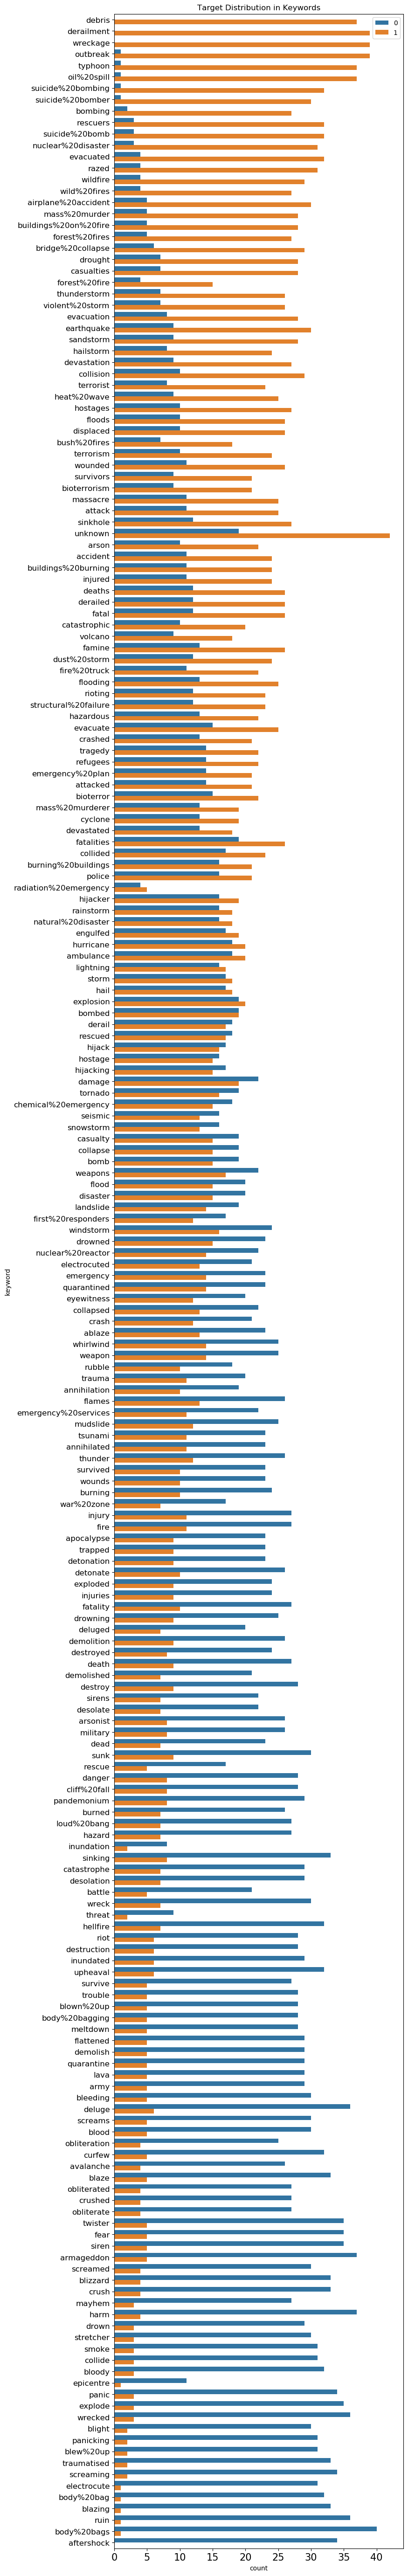

In [13]:
train_df_keyword['target_mean'] = train_df_keyword.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100) #dpi= pixels/size of the plot

sns.countplot(y=train_df_keyword.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df_keyword.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df_keyword.drop(columns=['target_mean'], inplace=True)

# 2. Baseline models without processing <a class="anchor" id="2"></a>

## A. Baseline model for 'text'

The baseline model scores are not bad considering that we did not do any text processing yet.
However, if we look at the features' importance, they don't seem to make much sense.
We will try to improve the scores and improve the features that matter too.
We want words that relate to disasters for a human being to come up in the list.
Same goes for the features that are irrelevant.

(6090, 18564)
accuracy = 0.802, precision = 0.802, recall = 0.802, f1 = 0.800
cross-validation F1 scores: [0.71896723 0.73392681 0.73705179 0.71302644 0.75528701]


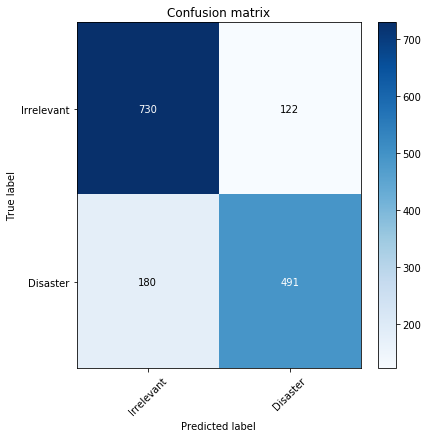

[[730 122]
 [180 491]]


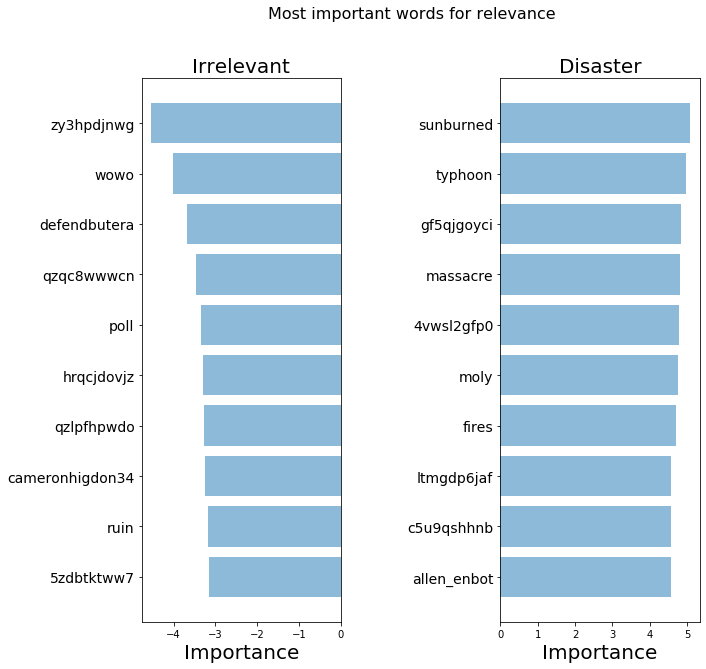

In [14]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv') 
test_df['target'] = 0
dataset = train_df.append(test_df).reset_index(drop=True)

train_df2 = dataset.loc[:7612]

test_df2 = dataset.loc[7613:]   


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_df2["text"].tolist()  
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40) # so we have the same results when re-running code

X_train_counts, count_vectorizer = cv(X_train) #emb = X_train_counts, #count_vectorizer =itself (cf 'return' of our function)
X_test_counts = count_vectorizer.transform(X_test)
#list_corpus
print(X_train_counts.shape)

from sklearn.linear_model import LogisticRegression

clf_LR1 = LogisticRegression(max_iter =20 ,C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40)
clf_LR1.fit(X_train_counts, y_train)

y_predicted_counts = clf_LR1.predict(X_test_counts) #predictions on the test part (of the train set really ie. for cross val)

#print different score measures
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# cross-validation method 1
scores = model_selection.cross_val_score(clf_LR1, X_train_counts, y_train, scoring='f1', cv=5)
print("cross-validation F1 scores:",scores)

#confusion matrix
cm_LR1 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_LR1, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_LR1)


#feature importance
importance = get_most_important_features(count_vectorizer, clf_LR1, 10)
#plot the words
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


In [15]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy', 'F1 score'])
results_df.loc[len(results_df)] = ['Baseline model', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492


## B. Baseline model for 'keyword'

The score is also not bad.
If we look at the feature importance, both the irrelevant and relevant features could relate to a disaster really.
So from now on, we will focus on the text itself rather than the keywords.

(6090, 230)
accuracy = 0.720, precision = 0.726, recall = 0.720, f1 = 0.721
cross-validation F1 scores: [0.70932358 0.69658887 0.68698061 0.67712177 0.67910448]


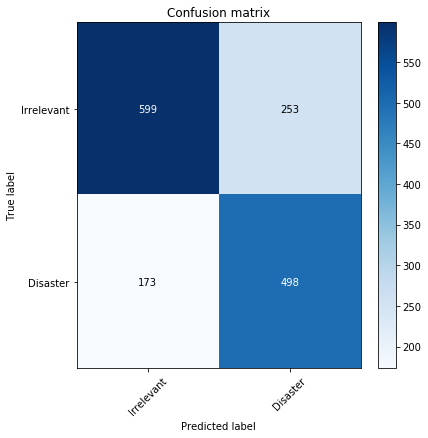

[[599 253]
 [173 498]]


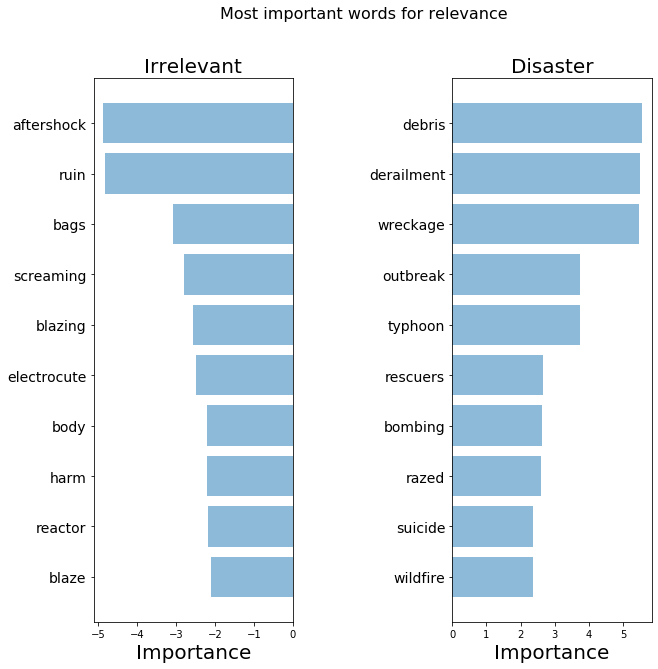

In [16]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv') 
test_df['target'] = 0
dataset = train_df.append(test_df).reset_index(drop=True)


# replace NA's so we can run the model
dataset = dataset.fillna('unknown')


#replace %20 by a white space

dataset = standardize_keyword(dataset,'keyword')


train_df2 = dataset.loc[:7612]

test_df2 = dataset.loc[7613:]   


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_df2["keyword"].tolist()  
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40) # so we have the same results when re-running code

X_train_counts, count_vectorizer = cv(X_train) #emb = X_train_counts, #count_vectorizer =itself (cf 'return' of our function)
X_test_counts = count_vectorizer.transform(X_test)
#list_corpus
print(X_train_counts.shape)

from sklearn.linear_model import LogisticRegression

clf_LR1 = LogisticRegression(max_iter =20 ,C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40)
clf_LR1.fit(X_train_counts, y_train)

y_predicted_counts = clf_LR1.predict(X_test_counts) #predictions on the test part (of the train set really ie. for cross val)

#print different score measures
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# cross-validation method 1
scores = model_selection.cross_val_score(clf_LR1, X_train_counts, y_train, scoring='f1', cv=5)
print("cross-validation F1 scores:",scores)

#confusion matrix
cm_LR1 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_LR1, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_LR1)


#feature importance
importance = get_most_important_features(count_vectorizer, clf_LR1, 10)
#plot the words
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


# 3. Keeping duplicated rows <a class="anchor" id="3"></a>
Below we experiment an algorithm after removing duplicates.
This step is created for the following reasons:
- once we clean the data in the next part, we can see that we actually have duplicated entries, i.e. observations that contain the exact same information for the columns text, location, keyword and target.
- we were able to stop these duplicates only after we cleaned the data.
- for the notebook to make more sense though, we show this step first to explain why we later keep the duplicates for the rest of the analysis. <br>

Model without duplicates:
- the distribution of the target value is not balanced anymore (see plot below)
- the scores are worse than the baseline model 
- the feature of importance make more sense than initial baseline
- really bad at identifying true positives, good for true negatives
- we decided to drop the duplicates and keep the first entry
- even using TF-IDF which should yield better results, we don't match the baseline model <br>

Conclusion: we decided to keep the duplicates for the training and testing of different models because:
- there are not many exact duplicates
- removing them causes unbalance in the distribution of the target value

accuracy = 0.726, precision = 0.733, recall = 0.726, f1 = 0.729
cross-validation F1 scores: [0.6183844  0.56358382 0.57894737 0.52148148 0.57863501]


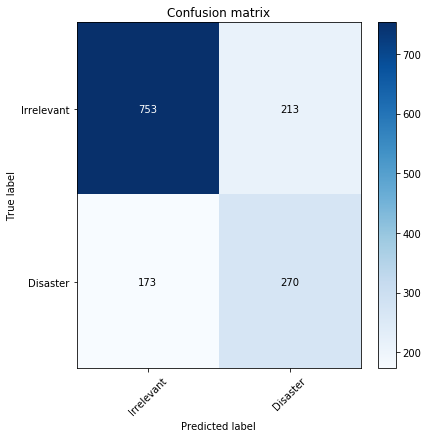

[[753 213]
 [173 270]]


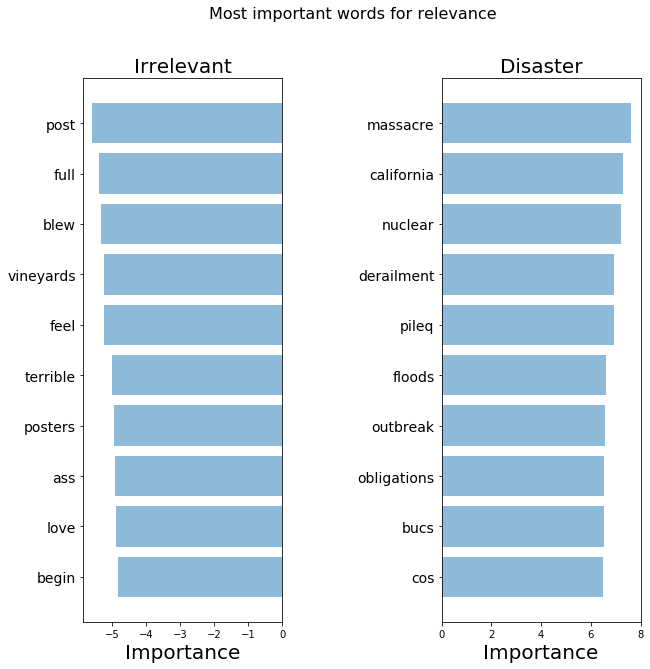

In [17]:
train_df3= dataset[dataset['id']< 7613] #select only id's from the train dataset
len(train_df3[train_df3.duplicated(['text','keyword', 'target', 'location'])].index.tolist())
train_no_duplicates = train_df3.drop_duplicates(subset=['text','keyword','target'], keep='first')
#remove duplicates for rows where text, keyword and target is the same
#train_df3[train_df3.duplicated(['text','keyword'])]
test_df  = pd.read_csv('test.csv') 
test_df['target'] = 0
dataset = train_no_duplicates.append(test_df).reset_index(drop=True)
dataset = standardize_text(dataset, "text")
train_df3 = dataset.loc[:7044]  # less observtions than initially since we remove the duplicated
test_df3 = dataset.loc[7045:]  

# get vectors
stopwords = sorted(list(nltk.corpus.stopwords.words('english')))

def cv(data):
    count_vectorizer = TfidfVectorizer(stop_words= stopwords )

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_df3["text"].tolist()  
list_labels = train_df3["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40) # so we have the same results when re-running code

X_train_counts, count_vectorizer = cv(X_train) #emb = X_train_counts, #count_vectorizer =itself (cf 'return' of our function)
X_test_counts = count_vectorizer.transform(X_test)
#list_corpus
X_train_counts.shape


#Model basic
from sklearn.linear_model import LogisticRegression

clf_LR1 = LogisticRegression(max_iter =20 ,C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40, penalty='l2')
clf_LR1.fit(X_train_counts, y_train)

y_predicted_counts = clf_LR1.predict(X_test_counts) #predictions on the test part (of the train set really ie. for cross val)

#print different score measures
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# cross-validation method 1
scores = model_selection.cross_val_score(clf_LR1, X_train_counts, y_train, scoring='f1', cv=5)
print("cross-validation F1 scores:",scores)

#confusion matrix
cm_LR1 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_LR1, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_LR1)


#feature importance
importance = get_most_important_features(count_vectorizer, clf_LR1, 10)
#plot the words
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The dataset is not balanced anymore. There are 2230 tweets for target 1 (disaster), and 4815 for 0 (not disaster).

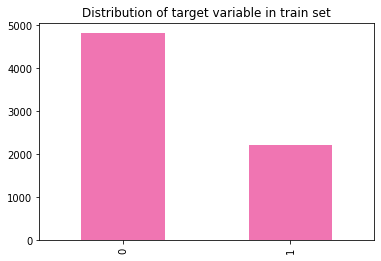

In [18]:
train_df3_target_1 = len(train_df3[train_df3['target']==1])
target_df3_target_0 = len(train_df3[train_df3['target']==0])
train_df3['target'].value_counts().plot(kind='bar', title = 'Distribution of target variable in train set', color =(0.9,0.1,0.5,0.6))
train_df.groupby('target').count()
md(f'The dataset is not balanced anymore. There are {train_df3_target_1} tweets for target 1 (disaster), and {target_df3_target_0} for 0 (not disaster).')

In [19]:
results_df.loc[len(results_df)] = ['No duplicates baseline model', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068


# 4. Data cleaning and pre-processing: <a class="anchor" id="4"></a>
Pre-processing is a very important step as the algorithm will depend on its performance. To decide whether a tweet is about a disaster or not, we must be able to define what is inside the tweet i.e. extract information from the words. Before applying any kind of algorithm we need to transform the data. Indeed, we cannot feed 'sentences' into the algorithms. <br>

Once the data is cleaned, we will split the text into 'tokens' for further processing. <br>

We will follow some of the advice given in this  <a href = 'https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e'>article</a> to clean the data.


Reminder: we are doing the pre-processing steps for both the train and test sets together ('dataset') so that we don't need to duplicate these steps when testing with the test set. Therefore, when trying out ML techniques to classify the tweets, we will split the training part of the dataset into other 'train' and 'test' sets for the purpose of cross validation. Finally, the real 'test' set is used to make the sumission.

- Tokenization is a process whereby we split an input string into tokens. It returns a sequence of tokens, e.g., words. 
- Bag-of-words representation does not take the order of the words into account. It returns the frequency of each token.

## A. Merge the train and test sets to clean both

In [20]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv') 
test_df['target'] = 0
dataset = train_df.append(test_df).reset_index(drop=True)

## B. Clean the data using regular expressions 
Here we are trying to remove some of the noise from the data using regular expressions:
- remove special characters
- lowercase all the text (which will improve tokenisation / bag of words representation)

In [21]:
#add the initial method to clean tweets
dataset = standardize_text(dataset, "text")

In [22]:
#example of changes after using regular expression: searching the text for a word is easier
print('For the train set before and after regular expressions (use rows from train in the dataset variable):')
print('number of times Canada appears: ', len([line for line in train_df['text'] if 'Canada' in line]))

print('number of times canada appears: ', len([line for line in train_df['text'] if 'canada' in line]))
print('number of times CANADA appears: ', len([line for line in train_df['text'] if 'CANADA' in line]))

print('number of times canada appears after regexp: ', len([line for line in dataset[0:7612]['text'] if 'canada' in line]))

For the train set before and after regular expressions (use rows from train in the dataset variable):
number of times Canada appears:  10
number of times canada appears:  3
number of times CANADA appears:  2
number of times canada appears after regexp:  14


In [23]:
# cleaning the keyword and location column
dataset = dataset.fillna('unknown')
dataset['keyword'] = dataset['keyword'].astype('str')


def standardize_keyword(dataset, keyword):
    dataset[keyword] = dataset[keyword].str.replace(r"%20", " ")
    dataset[keyword] = dataset[keyword].str.lower()
    return dataset

standardize_keyword(dataset,'keyword')
#[line for line in dataset['keyword'] if 'unknown' not in line and line.startswith('c')]

,id,keyword,location,text,target
0,1,unknown,unknown,our deeds are the reason of this earthquake m...,1
1,4,unknown,unknown,forest fire near la ronge sask canada,1
2,5,unknown,unknown,all residents asked to 'shelter in place' are ...,1
3,6,unknown,unknown,"13,000 people receive wildfires evacuation or...",1
4,7,unknown,unknown,just got sent this photo from ruby alaska as ...,1
...,...,...,...,...,...
10871,10861,unknown,unknown,earthquake safety los angeles safety faste...,0
10872,10865,unknown,unknown,storm in ri worse than last hurricane my city...,0
10873,10868,unknown,unknown,green line derailment in chicago,0
10874,10874,unknown,unknown,meg issues hazardous weather outlook (hwo),0


If we intially look at the data, there seemed to be no duplicates. However, this changes after cleaning the text (standardising text). There are some duplicates text wise, but the same text does not always contain the same location or same target.
So we will keep all of these cases where some data changes. 

Here we can see an agreement issue in the training set, where similar tweets belong to different classes.
Otherwise we would be 'shooting' in the dark by deciding which version to keep for the training set.


## C. Pre-processing - Tokenisation i.e. Building a matrix (sparse)

- tokenise sentences into lists of words
- In order for the tokens to be representative and avoid repetition, we will lowercase all the words so  'NIGHT' and 'night' will be represented by the same token.
- Another important part is to remove the special characters: '#night' and 'night will be represented by the same token.
    - Same will be done with punctuation marks 

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #similar as the trial notebook but import so no need to call 
#count_vectorizer= 'feature_extraction.text'.CountVectorizer() --> directly use countVectorizer()

#dataset.loc[dataset[:7612, dataset['text']]]

#using the 'dataset' i.e. cleaned data to rebuild a new train_df2
#then build the vectors/matrix 
# yields different result than doing if from raw data (initial train_df) 
# less columns since words have been cleaned

train_df2 = dataset.loc[:7612]

test_df2 = dataset.loc[7613:]       

count_vect_1= CountVectorizer()
X_train_counts = count_vect_1.fit_transform(train_df2['text'])

#Tokenise to create an additional column where each row is a list of tokens from the text
dataset['tokens'] =[nltk.word_tokenize(words) for words in dataset['text']]

print(X_train_counts.shape)

# vocabulary for train + test
all_words = [word for tokens in dataset['tokens'] for word in tokens]
#len(all_words)

sentence_lengths = [len(tokens) for tokens in dataset['tokens']]

vocab = sorted(list(set(all_words)))
len(vocab)
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

(7613, 14717)
162986 words total, with a vocabulary size of 18512
Max sentence length is 72


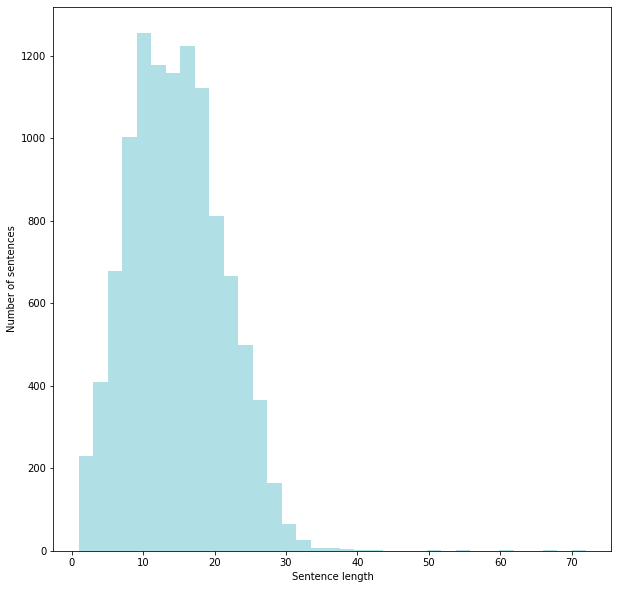

In [25]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, bins= 35, color ='powderblue')
plt.show()

# 5. Applying Machine Learning Techniques <a class="anchor" id="5"></a>
- We split the training part of the dataset into 'train' and 'test'
- This will allow to perform cross-validation on the different techniques we look at.


In [26]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv') 
test_df['target'] = 0
dataset = train_df.append(test_df).reset_index(drop=True)

dataset = standardize_text(dataset, "text")
train_df2 = dataset.loc[:7612]

In [27]:
dataset

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1
...,...,...,...,...,...
10871,10861,NaN,NaN,earthquake safety los angeles safety faste...,0
10872,10865,NaN,NaN,storm in ri worse than last hurricane my city...,0
10873,10868,NaN,NaN,green line derailment in chicago,0
10874,10874,NaN,NaN,meg issues hazardous weather outlook (hwo),0


In [28]:
[line for line in dataset['text'] if '?' in line]

["what's up man?",
 'do you like pasta?',
 'had an awesome time visiting the cfc head office the ancop site and ablaze  thanks to tita vida for taking care of us ??',
 'soooo pumped for ablaze ???? ',
 'i gained 3 followers in the last week  you? know your stats and grow with ',
 "noches el bestia ' happy to see my teammates and training hard ?? goodnight gunners ?????? ",
 " what time does your talk go until? i don't know if i can make it due to work ",
 ' had a  personalinjury accident this summer? read our advice  amp  see how a  solicitor can help  otleyhour',
 'the pastor was not in the scene of the accident      who was the owner of the range rover ?',
 "mom  'we didn't get home as fast as we wished' \nme  'why is that?'\nmom  'there was an accident and some truck spilt mayonnaise all over ??????",
 "i was in a horrible car accident this past sunday  i'm finally able to get around  thank you god??",
 'can wait to see how pissed donnie is when i tell him i was in another accident?

# 5.1. Fitting a classifier - Logistic Regressions
We will try several classifiers using regression technique.

Evaluation of the classifier:
- look at the metrics: accuracy, recall, precision and F1 scores
- cross validation for F1
- confusion matrix
- features of importance

Confusion matrix to interpret results
- In order to get a visual idea of the classification performance
- Note that we are looking at the predictions made on a slice of the actual 'train' test that we split earlier in train / test so that we can assess our predictions
- Reminder: our task is to improve the F1 score.
- F1 score: takes into consideration both precision and recall
    - precision = number of true positives / all predicted positives 
    - recall    = number of true positives / all observed positives (i.e. all samples that should have been classed as positive)
- F1 closer to 1 is better.

- In the case at hands, recall is important because we don't want to miss on real positives i.e. miss a disaster
- Precision is also important to see the how many 'disaster' predicitons were correct

### A. Logistic Regression
#### Bag of words
- Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.
- The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_df2["text"].tolist()  
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40) # so we have the same results when re-running code

X_train_counts, count_vectorizer = cv(X_train) #emb = X_train_counts, #count_vectorizer =itself (cf 'return' of our function)
X_test_counts = count_vectorizer.transform(X_test)
#list_corpus
X_train_counts.shape

#This is what our matrix looks like (the columns are the tokens/words)
our_features_df = pd.DataFrame(X_train_counts.A,columns = count_vectorizer.get_feature_names())
#our_features_df['fire']

### Visualise embeddings
- the classes are not discernable yet, we need to process the data further probably

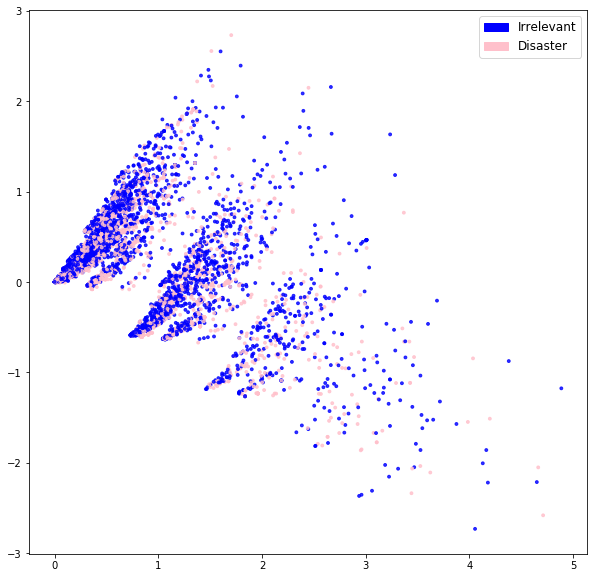

In [30]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

accuracy = 0.789, precision = 0.788, recall = 0.789, f1 = 0.788
cross-validation F1 scores: [0.71624266 0.73372781 0.71216617 0.7        0.732     ]
{'fit_time': array([0.1406467 , 0.1427567 , 0.12714624, 0.12964988, 0.12762141]), 'score_time': array([0.00102496, 0.00102139, 0.00103545, 0.00199604, 0.00103545]), 'test_score': array([0.71624266, 0.73372781, 0.71216617, 0.7       , 0.732     ])}


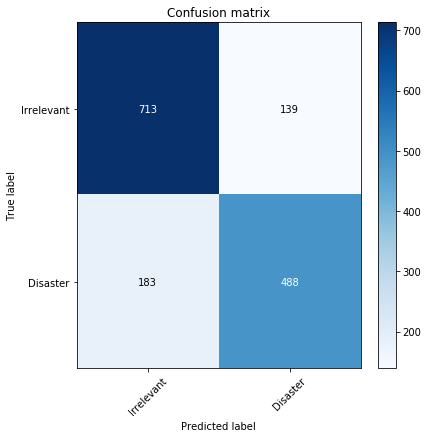

[[713 139]
 [183 488]]


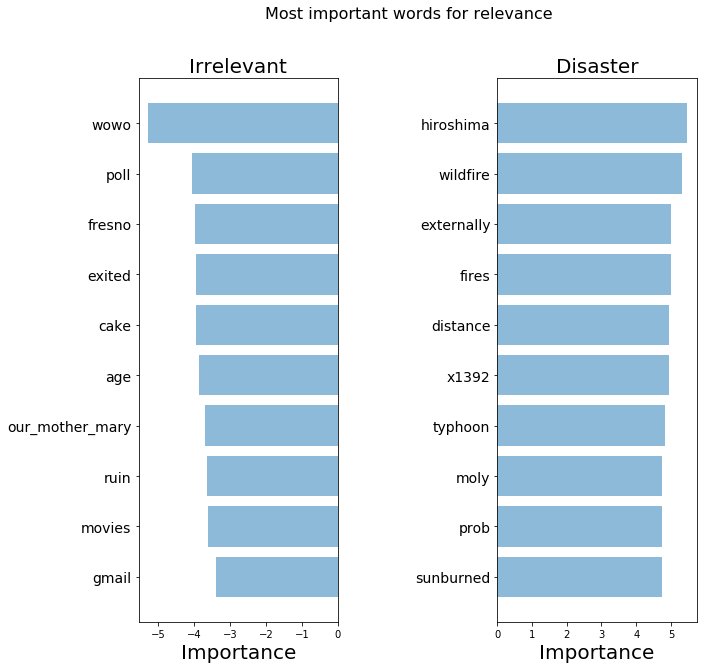

In [31]:
#model
from sklearn.linear_model import LogisticRegression

clf_LR1 = LogisticRegression(max_iter =20 ,C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40)
clf_LR1.fit(X_train_counts, y_train)

y_predicted_counts = clf_LR1.predict(X_test_counts) #predictions on the test part (of the train set really ie. for cross val)


accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# cross-validation method 1
scores = model_selection.cross_val_score(clf_LR1, X_train_counts, y_train, scoring='f1', cv=5)
print("cross-validation F1 scores:",scores)

# cross-validation method 2
from sklearn.model_selection import cross_validate
scores2 = cross_validate(clf_LR1, X_train_counts, y_train, scoring='f1')
print(scores2)

cm_LR1 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_LR1, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_LR1)

importance = get_most_important_features(count_vectorizer, clf_LR1, 10)
#plot the words
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The figure above shows that our model captures important word such as "wildfire" and "fires" which suggest a disaster. However, we might be able to improve the features by tweaking the data a little more (see below)

In [32]:
results_df.loc[len(results_df)] = ['Logistic Regression 1', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653


In [33]:
X_train_counts

<6090x12984 sparse matrix of type '<class 'numpy.int64'>'
	with 76264 stored elements in Compressed Sparse Row format>

In [34]:
test_vectors = count_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

<3263x12984 sparse matrix of type '<class 'numpy.int64'>'
	with 37025 stored elements in Compressed Sparse Row format>

In [35]:
#classifier_name.fit(X_train_counts, y_train)
#classifier_name.predict(test_vectors)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_LR1.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submissionLR1.csv', index = False)

In [36]:
# %who to check all variables
# del var_name to delete a variable

### B. Logistic Regression 2: removing stopwords

We can try to remove stop words as they are not necessarily informative
- by changing the parameter in the count_vectorzer or tf_idf vectorizer
- These words appear many times and don't add information so they are not really 'features' for our model
- Since out goal is not to do part-of-speech tag, we can remove stop word and it's okay to lose some context because what matters are specific words
- An example is given below: if we look at the initial our_features_df, we can see that words such as 'of' appear over 1,400 times

In [37]:
import nltk

from stop_words import get_stop_words
from nltk.corpus import stopwords

stop_ = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 179 stopwords
stop_list = sorted(set(stop_).union(set(nltk_words)))  # removing hash from stop words
print('Stopwords appear', len([element for element in all_words if element in stop_]), 'time in the dataset.') #over 5K times 'the', and 50K words are stopwords
print('There are', len(set([element for element in all_words if element in stop_])), 'distinct stopwords in the dataset.')

Stopwords appear 50576 time in the dataset.
There are 122 distinct stopwords in the dataset.


In [38]:
# unnecessary words (for our task):
print('number of times "of" appears:', our_features_df['of'].sum()) # try additional examples: 'this', 'that', 'of', 'it'
stopwords = sorted(list(nltk.corpus.stopwords.words('english')))
stopwords
print('Stopwords appear', len([element for element in all_words if element in stopwords]), 'time in the dataset.') #over 5K times 'the', and 50K words are stopwords
print('There are', len(set([element for element in all_words if element in stopwords])), 'distinct stopwords in the dataset.')

number of times "of" appears: 1471
Stopwords appear 52332 time in the dataset.
There are 144 distinct stopwords in the dataset.


In [39]:
# we re-do that step since we are adding a parameter to remove the stopwords
train_df2 = dataset.loc[:7612]
train_df2

def cv(data):
    count_vectorizer = CountVectorizer(stop_words = stop_list) #add parameter to remove stop_words from the list above 'stopwords'

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_df2["text"].tolist()  
list_labels = train_df2["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_counts # there are less columns since we removed the stopwords

#our_features_df2 = pd.DataFrame(X_train_counts.A,columns = count_vectorizer.get_feature_names())
#our_features_df2['this'] returns no output !! we removed the stop words effectively

C:\Users\Patricia Llull\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<6090x12842 sparse matrix of type '<class 'numpy.int64'>'
	with 52303 stored elements in Compressed Sparse Row format>

accuracy = 0.795, precision = 0.795, recall = 0.795, f1 = 0.794
cross-validation scores: [0.7221665  0.71921182 0.70459082 0.69813176 0.73259334]


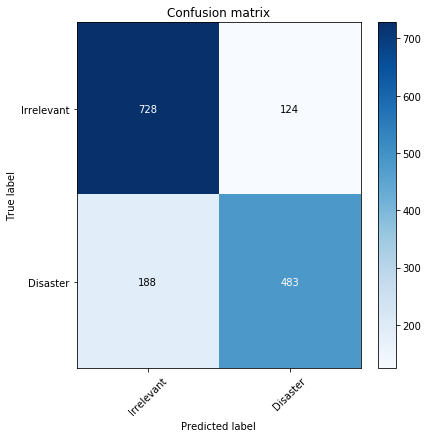

[[728 124]
 [188 483]]


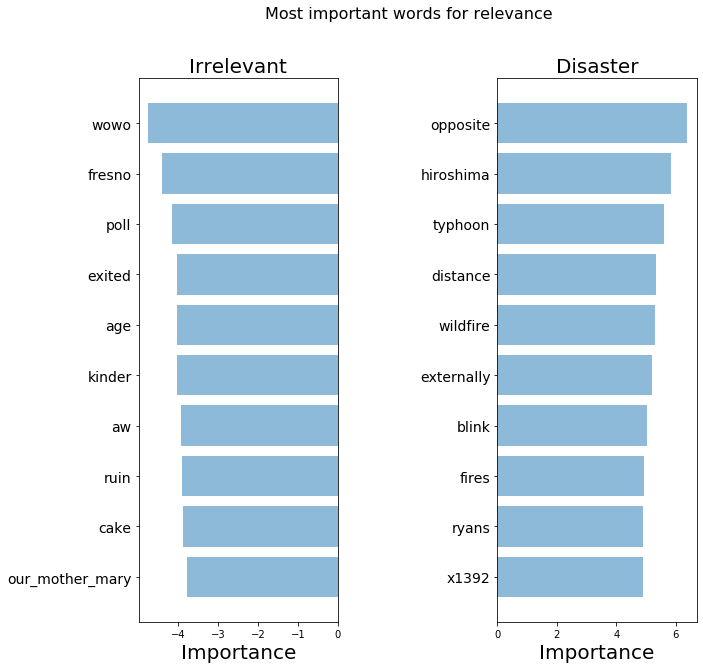

In [40]:
#model
clf_LR2 = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40, max_iter=100)
clf_LR2.fit(X_train_counts, y_train)

y_predicted_counts = clf_LR2.predict(X_test_counts) #predictions on the test part (of the train set really ie. for cross val)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
scores = model_selection.cross_val_score(clf_LR2, X_train_counts, y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)

#confusion matrix
cm2 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm2)

# get words importance
importance = get_most_important_features(count_vectorizer, clf_LR2, 10)
#plot the words
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

There is a slight improvement, but this might come at a cost: there are more True Negatives, a couple less True positives. And less false positives, and more false negatives. So an increase in scores might translate into 'missing' some disasters, which might put lives at risk.

In [41]:
results_df.loc[len(results_df)] = ['LR2 w/ stopwords', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720


In [42]:
test_vectors = count_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_LR2.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submissionLR2_stopwords.csv', index = False)

### C. Logistic Regression (TF-IDF on top of Bag of words and no stop words)
Since the result for the regression after removing stop words was slighly better, we can see that frequent words might just add noise and not information. Therefore we will now build on top of this and use a term frequency, inverse document frequency vectorizer.
- TF-IDF method will allow to further capture noise that was not captured in the stop words list
- It is a more subtle method: TF-IDF weighs the words based on their frequency in the dataset:
    - discount weights of words that are too frequent since they might reprensent noise
- In baseline models, we decided to keep duplicate entries. Ths method might help decrease the effect of the duplicates since words that appear more often will weigh less.
- let's see if this method improves our classifier

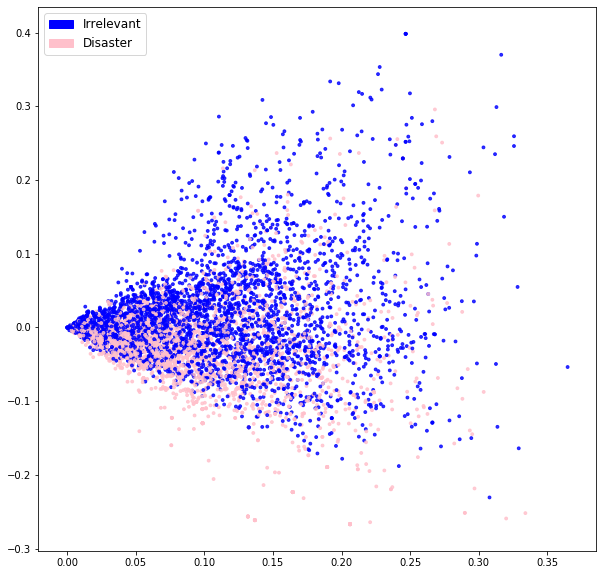

In [43]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer() #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# we can start to see the classes better than earlier
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

accuracy = 0.800, precision = 0.800, recall = 0.800, f1 = 0.800
cross-validation scores: [0.73286991 0.72452069 0.71724138 0.71005917 0.74650699]


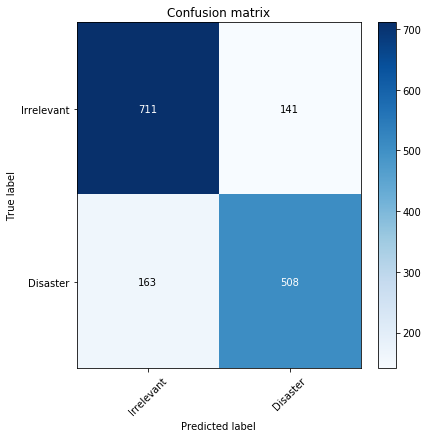

[[711 141]
 [163 508]]


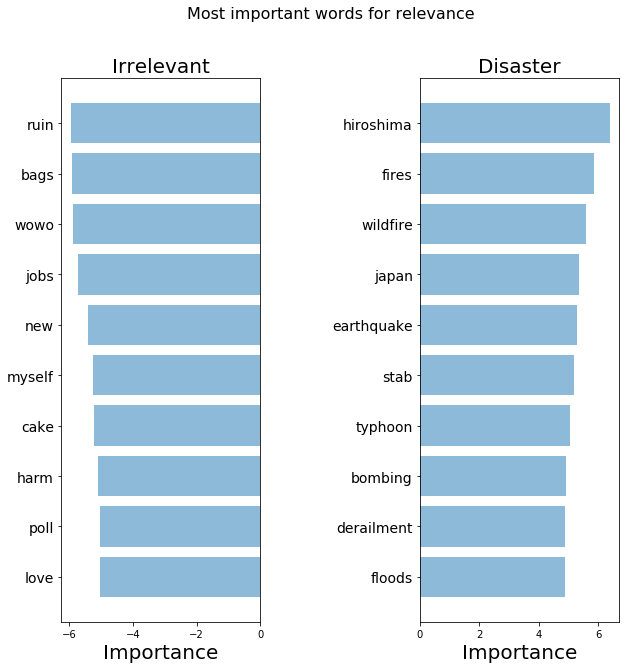

In [44]:
# model
clf_LRtfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='auto', n_jobs=-1, random_state=40)
clf_LRtfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_LRtfidf.predict(X_test_tfidf)

#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))

scores = model_selection.cross_val_score(clf_LRtfidf, X_train_tfidf, y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)

#confusion matrix
cm3 = confusion_matrix(y_test,y_predicted_tfidf)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm3, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm3)

### Feature importance
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_LRtfidf, 10)
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [45]:
results_df.loc[len(results_df)] = ['LR TF-IDF', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720
4,LR TF-IDF,0.800394,0.800003


The scores improve once more, and we manage to increase the True Positives significantly! 
If we take a look at the the feature importance, we can see that the words make sense for both irrelevant and relevant features. <br>
##### Feature importance
- The words are more relevant than earlier: now we have words such as derailment, flood, and stab
- These words seem to reflect potential disasters!
- In contrast, words such as cake and love indeed don't seem too important to detect disasters

In [46]:
test_vectors = tfidf_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_LRtfidf.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submissionLR_tfidf.csv', index = False)

# 5.2 Bayes models 

- Here we are going to try another family of algorithms
- We use the tf-idf vectozier since it's the one that yielded the best results earlier


#### A. Nave Bayes

accuracy = 0.617, precision = 0.655, recall = 0.617, f1 = 0.611
cross-validation scores: [0.63265306 0.62560778 0.62662338 0.632083   0.63812601]


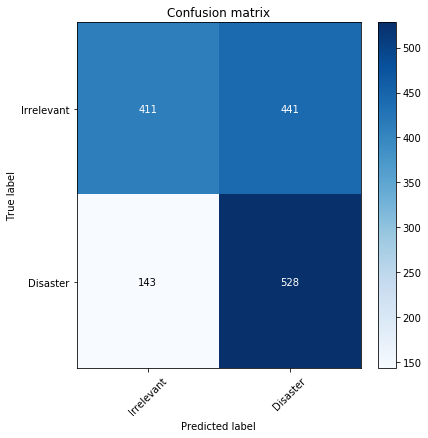

[[411 441]
 [143 528]]


In [47]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer() #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#model
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit(X_train_tfidf.todense(), y_train)
y_pred_NB = clf_NB.predict(X_test_tfidf.todense())


#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_pred_NB)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))
#cross-val
scores = model_selection.cross_val_score(clf_NB, X_train_tfidf.todense(), y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)


#confusion matrix
cm_NB = confusion_matrix(y_test, y_pred_NB)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_NB, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_NB)


### Feature importance
#cant find
#plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [48]:
results_df.loc[len(results_df)] = ['Gaussian NB', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720
4,LR TF-IDF,0.800394,0.800003
5,Gaussian NB,0.616546,0.610748


### B. Multinomial Bayes

accuracy = 0.813, precision = 0.818, recall = 0.813, f1 = 0.810
cross-validation scores: [0.73706897 0.74058127 0.73940678 0.72380952 0.73456121]


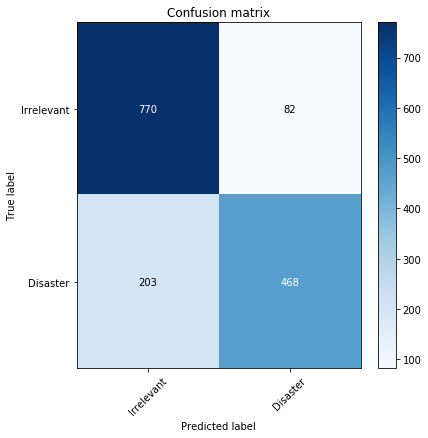

[[770  82]
 [203 468]]


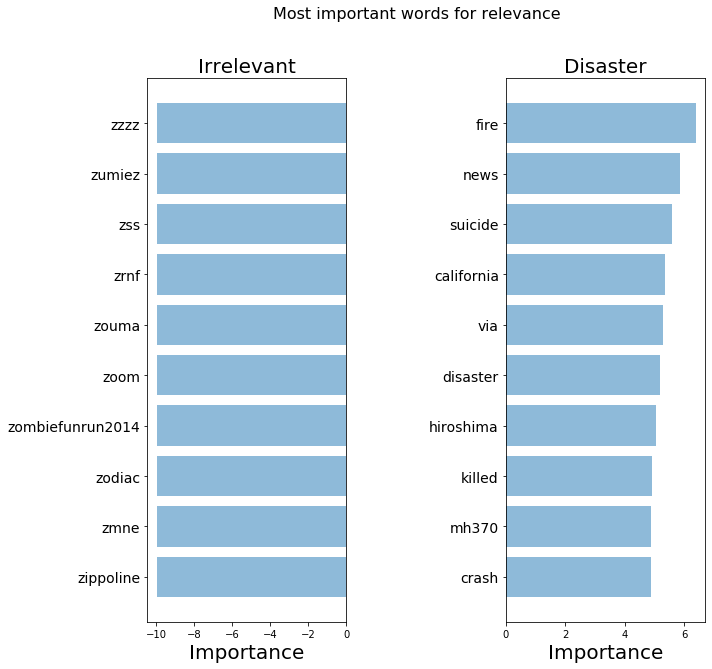

In [49]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords) #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# model

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf_bayes2 = MultinomialNB(alpha=0.9) # what is alpha?
clf_bayes2.fit(X_train_tfidf, y_train)
y_predicted_bayes2 = clf_bayes2.predict(X_test_tfidf) #on the 'test part of the training dataset'

accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_bayes2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))
scores = model_selection.cross_val_score(clf_bayes2, X_train_tfidf, y_train, scoring='f1', cv=5)
print('cross-validation scores:', scores)


#Confusion matrix
cm_bayes2 = confusion_matrix(y_test,y_predicted_bayes2)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_bayes2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_bayes2)

#feature importance
importance_bayes2 = get_most_important_features(tfidf_vectorizer, clf_bayes2, 10)
top_words = [a[1] for a in importance_bayes2[0]['tops']]
bottom_scores = [a[0] for a in importance_bayes2[0]['bottom']]
bottom_words = [a[1] for a in importance_bayes2[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [50]:
results_df.loc[len(results_df)] = ['Bayes2', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720
4,LR TF-IDF,0.800394,0.800003
5,Gaussian NB,0.616546,0.610748
6,Bayes2,0.812869,0.809801


In [51]:
test_vectors = tfidf_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_bayes2.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submission_multinomial_bayes2.csv', index = False)

## 5.3 Support Vector Machines
- let's see if this works better

In [52]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf_SVM = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='rbf'))
clf_SVM.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(C=100.0, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.01, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

accuracy = 0.790, precision = 0.789, recall = 0.790, f1 = 0.790
cross-validation scores: [0.73873874 0.73631841 0.7221665  0.71372549 0.74320242]


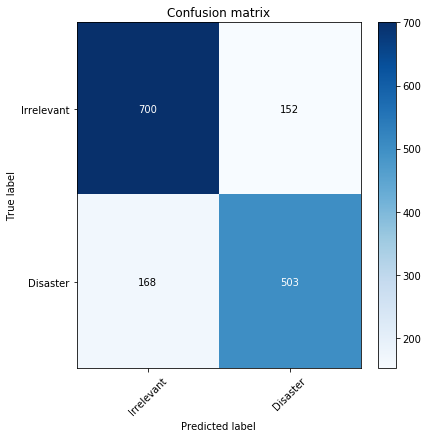

[[700 152]
 [168 503]]


In [53]:
#model
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf_SVM = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='rbf'))
clf_SVM.fit(X_train_tfidf, y_train)
y_predicted_counts = clf_SVM.predict(X_test_tfidf)

#scores
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
scores = model_selection.cross_val_score(clf_SVM, X_train_tfidf, y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)


#confusion matrix
cm_SVM1 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_SVM1, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_SVM1)

In [54]:
results_df.loc[len(results_df)] = ['SVM_1', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720
4,LR TF-IDF,0.800394,0.800003
5,Gaussian NB,0.616546,0.610748
6,Bayes2,0.812869,0.809801
7,SVM_1,0.789888,0.789598


In [55]:
clf_SVM.estimators_

[SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
     coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
     kernel='rbf', max_iter=-1, probability=True, random_state=None,
     shrinking=True, tol=0.001, verbose=False)]

In [56]:
clf_SVM.get_params()

{'estimator__C': 100.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': 'balanced',
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 0.01,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
     coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
     kernel='rbf', max_iter=-1, probability=True, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'n_jobs': None}

In [57]:
test_vectors = tfidf_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_SVM.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
#submission.to_csv('submissionSVM1.csv', index = False)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## SVM 2

accuracy = 0.803, precision = 0.803, recall = 0.803, f1 = 0.802
cross-validation scores: [0.73360656 0.72522983 0.72671443 0.71128871 0.7443299 ]


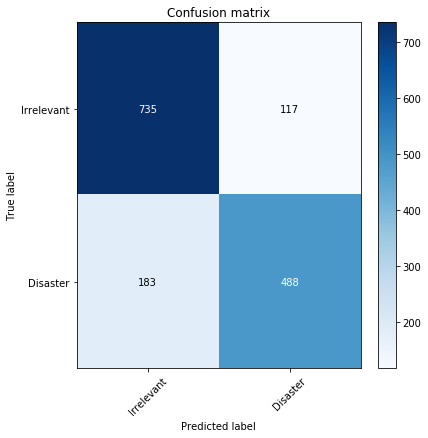

[[735 117]
 [183 488]]


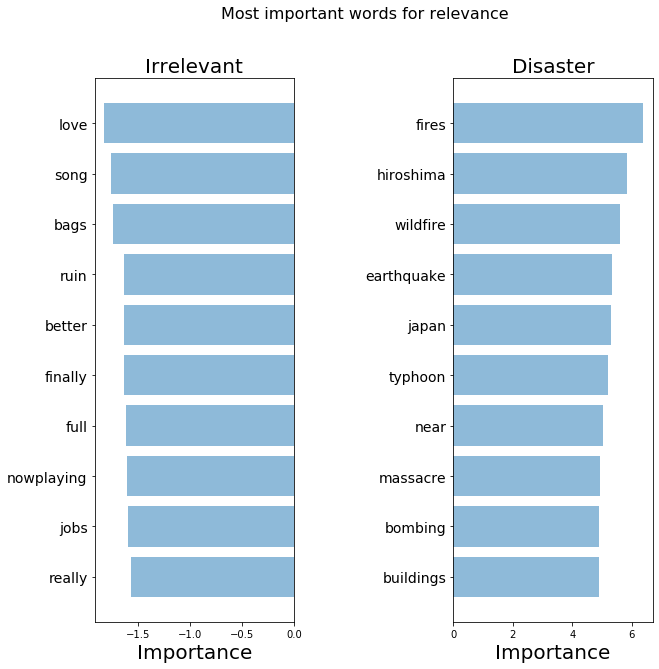

In [58]:
from sklearn.linear_model import SGDClassifier
clf_svm2 = SGDClassifier()
clf_svm2.fit(X_train_tfidf, y_train)
y_predicted_svm2 = clf_svm2.predict(X_test_tfidf)

#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_svm2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))
scores = model_selection.cross_val_score(clf_svm2, X_train_tfidf, y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)

#confusion matrix
cm_svm2 = confusion_matrix(y_test,y_predicted_svm2)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_svm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_svm2)

#features
importance_svm2 = get_most_important_features(tfidf_vectorizer, clf_svm2, 10)
top_words = [a[1] for a in importance_svm2[0]['tops']]
bottom_scores = [a[0] for a in importance_svm2[0]['bottom']]
bottom_words = [a[1] for a in importance_svm2[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


In [59]:
results_df.loc[len(results_df)] = ['SVM2', accuracy, f1]
results_df

test_vectors = tfidf_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)


<3263x12846 sparse matrix of type '<class 'numpy.float64'>'
	with 24355 stored elements in Compressed Sparse Row format>

In [60]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_svm2.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submission_svm2.csv', index = False)

## 5.4 Ridge (regression with regularisation)

accuracy = 0.814, precision = 0.814, recall = 0.814, f1 = 0.812
cross-validation scores: [0.73170732 0.7278481  0.72612802 0.71678682 0.74089936]


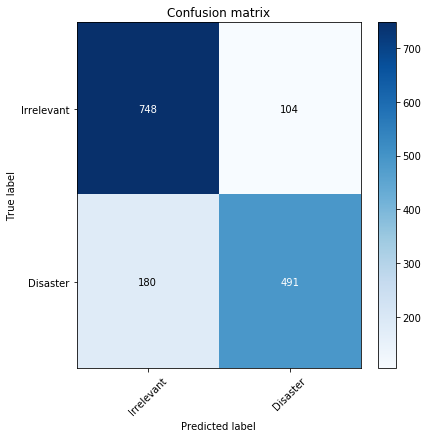

[[748 104]
 [180 491]]


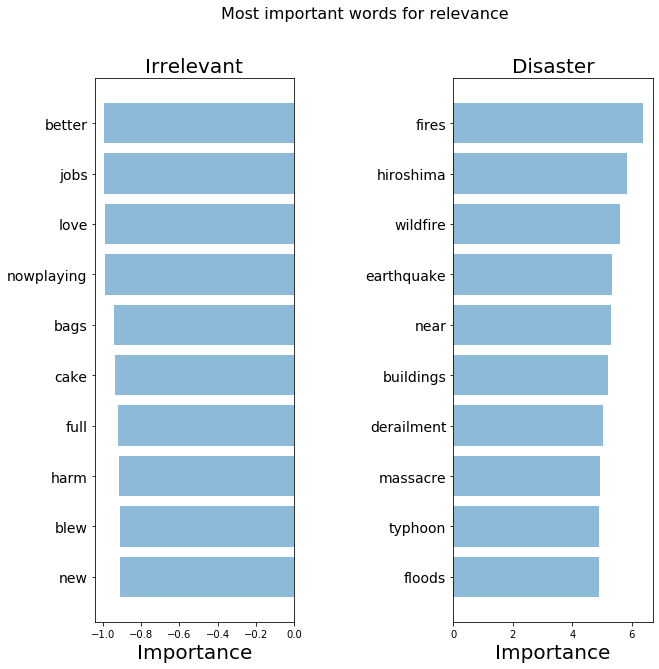

In [61]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords) #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#model
clf_ridge = linear_model.RidgeClassifier() #ridge for classification task
clf_ridge.fit(X_train_tfidf, y_train)

y_predicted_ridge = clf_ridge.predict(X_test_tfidf)

#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_ridge)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))
scores = model_selection.cross_val_score(clf_ridge, X_train_tfidf, y_train, scoring='f1', cv=5)
print('cross-validation scores:',scores)

#confusion matrix
cm_ridge = confusion_matrix(y_test,y_predicted_ridge)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_ridge, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_ridge)

#features
importance_ridge = get_most_important_features(tfidf_vectorizer, clf_ridge, 10)
top_words = [a[1] for a in importance_ridge[0]['tops']]
bottom_scores = [a[0] for a in importance_ridge[0]['bottom']]
bottom_words = [a[1] for a in importance_ridge[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


In [62]:
results_df.loc[len(results_df)] = ['Ridge', accuracy, f1]
results_df

,Approach,Accuracy,F1 score
0,Baseline model,0.801707,0.800492
1,No duplicates baseline model,0.726047,0.729068
2,Logistic Regression 1,0.788575,0.787653
3,LR2 w/ stopwords,0.795141,0.793720
4,LR TF-IDF,0.800394,0.800003
5,Gaussian NB,0.616546,0.610748
6,Bayes2,0.812869,0.809801
7,SVM_1,0.789888,0.789598
8,SVM2,0.803020,0.801599
9,Ridge,0.813526,0.811910


In [63]:
test_vectors = tfidf_vectorizer.transform(test_df2['text']) #same #columns as train_vectors i.e. uses same tokens
test_vectors

#clf.fit(X_train_counts, y_train)

submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf_ridge.predict(test_vectors)
submission['target'] = submission['target'].astype('int')
submission.head()
submission.to_csv('submission_ridge_tfidf.csv', index = False)

### Decision Tree

accuracy = 0.735, precision = 0.734, recall = 0.735, f1 = 0.734


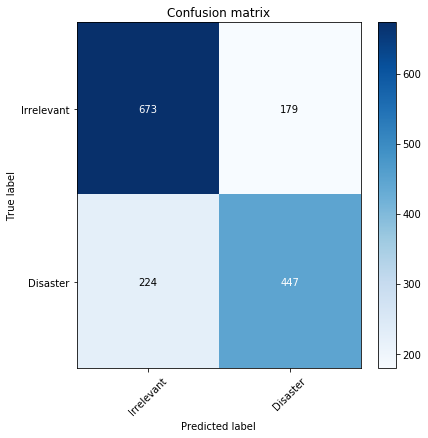

[[673 179]
 [224 447]]


In [64]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords) #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# model
from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier(criterion ='entropy')

clf_DT.fit(X_train_tfidf, y_train)
y_predicted_DT = clf_DT.predict(X_test_tfidf) #on the 'test part of the training dataset'

#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_DT)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))


#Confusion matrix
cm_DT = confusion_matrix(y_test,y_predicted_DT)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_DT, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_DT)

#feature importance

## Random forest

accuracy = 0.785, precision = 0.786, recall = 0.785, f1 = 0.783


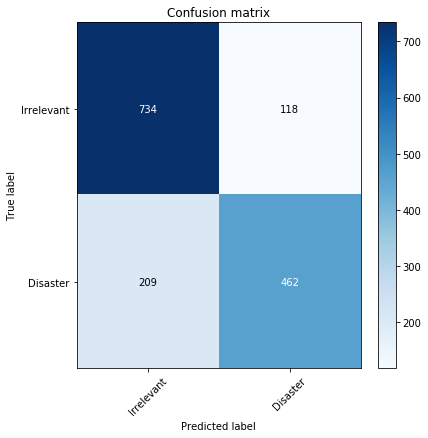

[[734 118]
 [209 462]]


In [65]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords) #stop_words= stopwords parameter

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# model
from sklearn.ensemble import RandomForestClassifier

clf_DT = RandomForestClassifier()

clf_DT.fit(X_train_tfidf, y_train)
y_predicted_DT = clf_DT.predict(X_test_tfidf) #on the 'test part of the training dataset'

#scores
accuracy, precision, recall, f1= get_metrics(y_test, y_predicted_DT)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, 
                                                                       recall, f1))


#Confusion matrix
cm_DT = confusion_matrix(y_test,y_predicted_DT)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_DT, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm_DT)

#feature importance


Recap of what has been done:
- we have cleaned the data
- we looked at baseline models and decided to look into the 'text' column rather than the 'keyword' column. 
- we tried a variety of algorithm that give different results: some are better at classified true negatives, other are good at classifying true positives and so on.
- our task is to detect disasters so we want a model that is good a classifying disasters as such
- we also need the model to classify non-disasters as such
- what is important too is to minimise the false negatives i.e. miss a disaster, since there are lives at risk


What else can be done?
- for those who have better python skills, it would be interesting to look into the text as well as the keyword in combination.
- twitter data is said to be noisy and sparse: typos, abbreviations, etc and the fact that the text is short make it hard to analyse.
- use part-of-speech tagging, it was not done here since the disasters is not as straight forward as sentiment analysis, where adjectives are key. Disasters can be described with location, verbs, nouns and adjectives 
- use the number of urls and retweets: news tweets are more likely to be tweeted

In [66]:
# notebooks
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb <br>
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e <br>
https://towardsdatascience.com/build-and-compare-3-models-nlp-sentiment-prediction-67320979de61 
- how does the algo work on new words
- missspellings https://www.kaggle.com/nxhong93/tweet-predict1

SyntaxError: invalid syntax (<ipython-input-66-91b1ab1fad5b>, line 2)